目录结构：

1、<font color=red >集成的问题</font>

2、lightgbm为什么很低

3、get_dummies和labelencoder的问题

4、相关性问题

5、数据的填充问题

6、关于集成的高级选项：http://ml-ensemble.com/

## <font color=red>集成问题--三个臭皮匠等于一个诸葛亮</font>

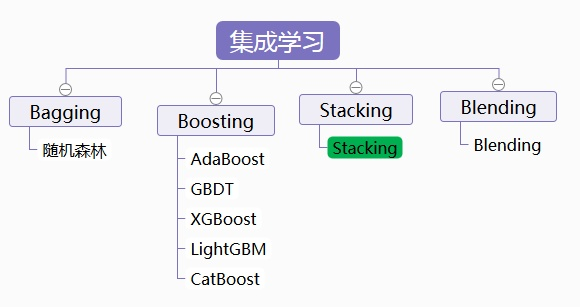

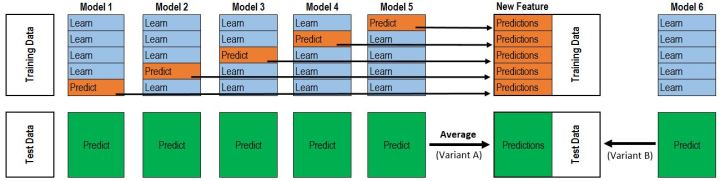

100条，均分成5份，1份用来做交叉验证（测试集），那么其中4份就看成训练集，那么就进行五次预测就得到了新特征。

每一次还要对测试集进行预测

In [ ]:
class stacking(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self,mod,meta_model):
        self.mod = mod#模型第一层
        self.meta_model = meta_model#元模型
        self.kf = KFold(n_splits=5, random_state=42, shuffle=True)##这就是堆叠的最大特征进行了几折的划分
        
    def fit(self,X,y):
        self.saved_model = [list() for i in self.mod]#保存模型
        oof_train = np.zeros((X.shape[0], len(self.mod)))#这里就得到一个训练集的行数x模型的个数的（mxn）的一个矩阵
        
        for i,model in enumerate(self.mod):#返回的是索引和模型本身
            for train_index, val_index in self.kf.split(X,y):##返回的是数据本身
                renew_model = clone(model)##模型的复制
                renew_model.fit(X[train_index], y[train_index])#对数据进行训练
                self.saved_model[i].append(renew_model)##把模型添加进去
                oof_train[val_index,i] = renew_model.predict(X[val_index])#得到新的预测数据集
        
        self.meta_model.fit(oof_train,y)#元模型（放到元模型里面去训练）
        return self
    
    def predict(self,X):##这里的话就相当于对他进行数据重构
        whole_test = np.column_stack([np.column_stack(model.predict(X) for model in single_model).mean(axis=1) 
                                      for single_model in self.saved_model]) ##得到的是整个测试集
        return self.meta_model.predict(whole_test)#返回的是利用元模型来对整个测试集进行预测
    
    def get_oof(self,X,y,test_X):#这是将第一层的特征提取出来再和原始特征进行拼接
        oof = np.zeros((X.shape[0],len(self.mod)))#M x N
        test_single = np.zeros((test_X.shape[0],5))##test-M x 5#单个模型测试
        test_mean = np.zeros((test_X.shape[0],len(self.mod)))#所有的求均值
        for i,model in enumerate(self.mod):##i是模型索引--进来模型
            for j, (train_index,val_index) in enumerate(self.kf.split(X,y)):##j是所有划分成五折好的的数据--进来数据
                clone_model = clone(model)##克隆模块，相当于把模型复制一下
                clone_model.fit(X[train_index],y[train_index])##把分割好的数据进行训练
                oof[val_index,i] = clone_model.predict(X[val_index])##对验证集进行预测 s
                test_single[:,j] = clone_model.predict(test_X)##对测试集进行预测
            test_mean[:,i] = test_single.mean(axis=1)##测试集算好均值
        return oof, test_mean#返回的是M X N和最后得到的测试的均值

In [1]:
import pandas as pd

In [2]:
pd.get_dummies(["A","B","C"])#维度灾难

,A,B,C
0,1,0,0
1,0,1,0
2,0,0,1


In [3]:
from sklearn.preprocessing import LabelEncoder

In [4]:
lab = LabelEncoder()#字符转化为字符

In [5]:
lab.fit_transform(["A","B","C"])

array([0, 1, 2], dtype=int64)

四、相关性问题

1、对于feature_importance进行特征选择的时候我们一般选择特征为正相关的

2、对于高相关性的特征我们一般采用降维的方式，不删


五、数据的填充问题（结合pandas_profiling）

用0填充的一般是缺失的比较多数值型的

用none填充的一般是缺失的字符串

用均值填充的一般是缺失少部分的数值型